# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from assembly import Assembly
from utils import load_yaml, num_params, num_trainable_params

In [3]:
sns.set(font_scale=1.25, style="whitegrid")

# Ignore known warnings that come when constructing subnets.
warnings.filterwarnings("ignore", message=".*The parameter 'pretrained' is deprecated.*")
warnings.filterwarnings("ignore", message=".*Arguments other than a weight enum.*")
warnings.filterwarnings("ignore", message=".*already erased node.*")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device = {device}")

NUM_CORES = os.cpu_count()
if hasattr(os, "sched_getaffinity"):
    # This function is only available on certain platforms. When running with Slurm, it can tell us the true
    # number of cores we have access to.
    NUM_CORES = len(os.sched_getaffinity(0))
print (f"Using {NUM_CORES} cores.")

Using 8 cores.


# Scan Files

Find all result files. Combine into a single dataframe.

In [4]:
project_name = "across-scales"
calc_num_params = True
proj_dir = Path("../experiments") / project_name
seed_pattern = re.compile(r"result-(\d+)\.pkl")

cached_metas = {}
metas = []
results = []
for resfile in sorted(proj_dir.rglob("result*.pkl")):
    if resfile.is_file():
        if resfile.parent not in cached_metas:
            meta = load_yaml(resfile.parent / "metadata.yml")
            cached_metas[resfile.parent] = meta
            if calc_num_params:
                cfg = load_yaml(resfile.parent / "config.yml")
                model = Assembly(cfg["assembly"], cfg.get("head"), input_shape=[3, 224, 224])
                meta["num_params"] = num_params(model)
                meta["num_trainable_params"] = num_trainable_params(model)

        meta = cached_metas[resfile.parent].copy()  # Important to copy so we don't write to the original.
        metas.append(meta)
        try:
            meta["seed"] = int(seed_pattern.match(resfile.name).group(1))
        except AttributeError:
            print("Unable to parse seed:", resfile)
            raise
        results.append(pd.read_pickle(resfile))

In [5]:
print(metas[0])
results[0]

{'adapter': 'block_with_downsample', 'arch': 'mobilenet-v3', 'first_deleted_block': 1, 'last_deleted_block': 1, 'num_downsamples': 0, 'num_params': 21117224, 'num_trainable_params': 10464, 'seed': 12345}


,Epoch,Step,Time/Data,LR,Loss,Time/Img Per Sec,Max Mem,Accuracy,Time/Step,Overall/Train Loss,Overall/Train Accuracy,Overall/Test Accuracy,Time/Total,Time/Per Epoch
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2503,1,2503,0.000319,0.002000,1.546190,94.425249,4877.767090,0.722222,0.762827,1.999528,0.601748,0.71600,2769.267798,2769.268777
5006,2,5006,0.000123,0.001951,1.286014,770.034673,1994.129395,0.722222,0.093625,1.566028,0.670622,0.73374,5540.621554,2771.351638
7509,3,7509,0.000139,0.001809,1.445410,776.056289,1994.129395,0.694444,0.092915,1.469275,0.687217,0.73688,8289.042596,2748.419793
10012,4,10012,0.000170,0.001588,1.483688,780.507057,1994.129395,0.680556,0.092417,1.433174,0.693317,0.73814,11026.609425,2737.565727
12515,5,12515,0.000176,0.001309,1.466748,696.138808,1994.129395,0.680556,0.103603,1.413563,0.697019,0.73764,13759.668759,2733.058148
15018,6,15018,0.000141,0.001000,1.613015,781.531148,1994.129395,0.625000,0.092267,1.400717,0.698629,0.74170,16519.975104,2760.304254
17521,7,17521,0.000129,0.000691,1.545636,767.170818,1994.129395,0.694444,0.093979,1.392076,0.699940,0.74166,19271.284213,2751.306827
20024,8,20024,0.000170,0.000412,1.214846,781.296603,1994.129395,0.777778,0.092324,1.381047,0.701856,0.74300,22033.869341,2762.583565
22527,9,22527,0.000145,0.000191,1.832417,780.140089,1994.129395,0.652778,0.092435,1.379921,0.702325,0.74208,24772.456062,2738.585562


In [6]:
full_df = pd.concat(results, keys=[tuple(m.values()) for m in metas], names=list(metas[0].keys()) + ["Step"])
full_df.set_index("Epoch", append=True, inplace=True)
full_df

Step  \
adapter                arch         first_deleted_block last_deleted_block num_downsamples num_params num_trainable_params seed  Step  Epoch          
block_with_downsample  mobilenet-v3 1                   1                  0               21117224   10464                12345 0     0          0   
                                                                                                                                 2503  1       2503   
                                                                                                                                 5006  2       5006   
                                                                                                                                 7509  3       7509   
                                                                                                                                 10012 4      10012   
...                                                                                                                                             ...   
downsample_then_linear swin-t       1                   6                  3               15351736   392448               67890 15018 6      15018   
                                                                                                                                 17521 7      17521   
                                                                                                                                 20024 8      20024   
                                                                                                                                 22527 9      22527   
                                                                                                                                 25030 10     25030   

                                                                                                                                              Time/Data  \
adapter                arch         first_deleted_block last_deleted_block num_downsamples num_params num_trainable_params seed  Step  Epoch              
block_with_downsample  mobilenet-v3 1                   1                  0               21117224   10464                12345 0     0            NaN   
                                                                                                                                 2503  1       0.000319   
                                                                                                                                 5006  2       0.000123   
                                                                                                                                 7509  3       0.000139   
                                                                                                                                 10012 4       0.000170   
...                                                                                                                                                 ...   
downsample_then_linear swin-t       1                   6                  3               15351736   392448               67890 15018 6       0.000228   
                                                                                                                                 17521 7       0.000147   
                                                                                                                                 20024 8       0.000133   
                                                                                                                                 22527 9       0.000131   
                                                                                                                                 25030 10      0.000214   

                                                                                                                                                    LR  \
adapter  

In [7]:
final_df = full_df.loc[full_df.index.get_level_values("Epoch") == full_df.index.get_level_values("Epoch").max()]

# Plots

In [8]:
def plot_accuracy_vs_depth(selected_arch, **kwargs):
    one_arch = final_df.loc[final_df.index.get_level_values("arch") == selected_arch]
    adapter_order = ["block_with_downsample",
                     "downsample_then_block",
                     "conv3x3_with_downsample",
                     "downsample_then_3x3conv",
                     "downsample_then_linear",
                     "finetune"]
    ax = sns.lineplot(one_arch, x="last_deleted_block", y="Overall/Test Accuracy", hue="adapter",
                      hue_order=adapter_order, marker="o", markersize=7, errorbar="sd", **kwargs)
    ax.set_title(selected_arch)


def plot_accuracy_vs_size(selected_arch, **kwargs):
    one_arch = final_df.loc[final_df.index.get_level_values("arch") == selected_arch]
    adapter_order = ["block_with_downsample",
                     "downsample_then_block",
                     "conv3x3_with_downsample",
                     "downsample_then_3x3conv",
                     "downsample_then_linear",
                     "finetune"]
    ax = sns.scatterplot(one_arch, x="num_params", y="Overall/Test Accuracy", hue="adapter", hue_order=adapter_order,
                         **kwargs)
    ax.set_title(selected_arch)

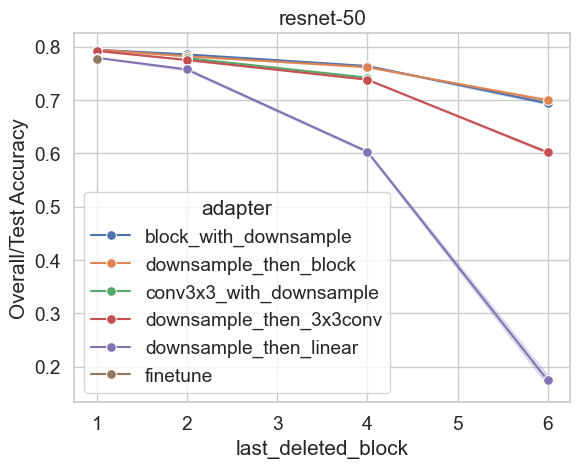

In [9]:
plot_accuracy_vs_depth("resnet-50")

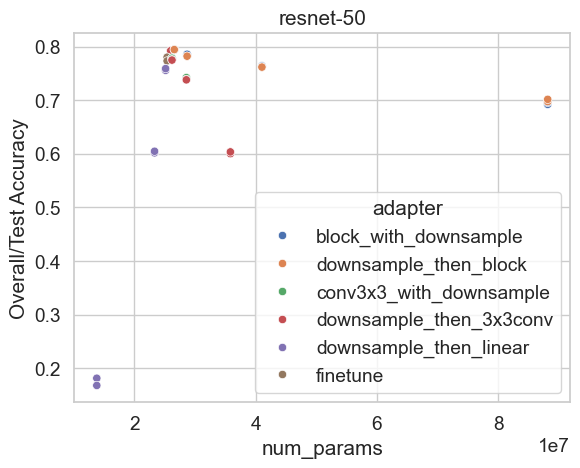

In [10]:
plot_accuracy_vs_size("resnet-50")

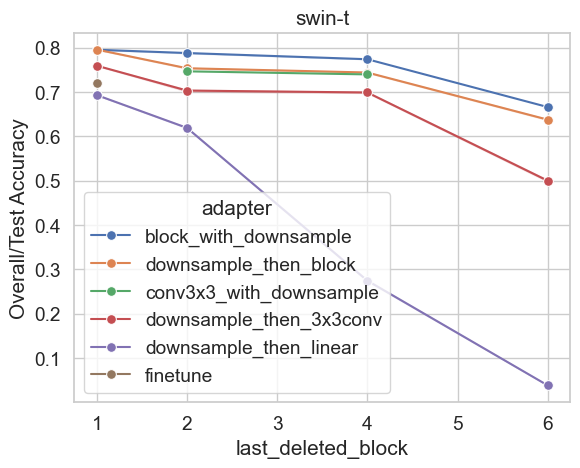

In [11]:
plot_accuracy_vs_depth("swin-t")

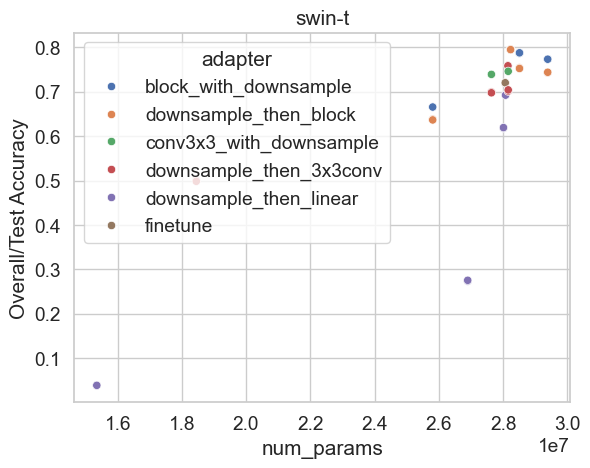

In [12]:
plot_accuracy_vs_size("swin-t")

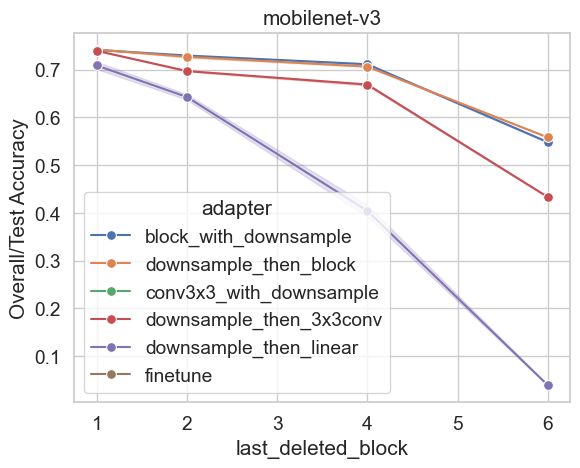

In [13]:
plot_accuracy_vs_depth("mobilenet-v3")

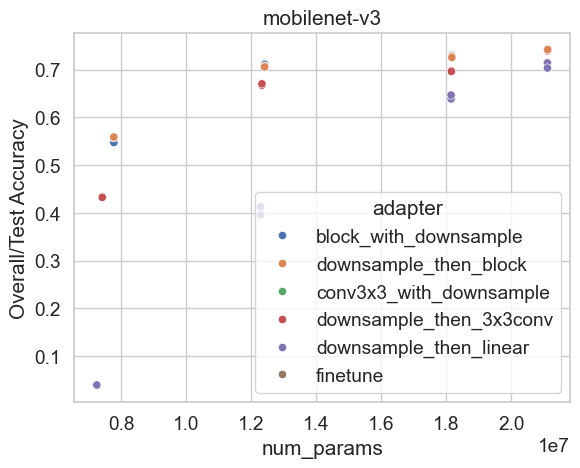

In [14]:
plot_accuracy_vs_size("mobilenet-v3")

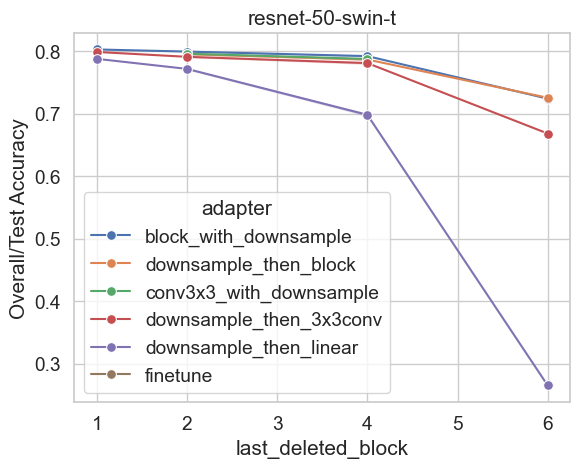

In [15]:
plot_accuracy_vs_depth("resnet-50-swin-t")

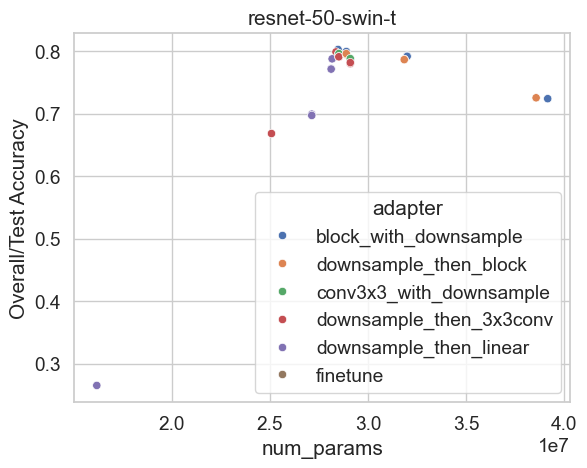

In [16]:
plot_accuracy_vs_size("resnet-50-swin-t")

# Sandbox

In [17]:
final_df.loc[final_df.index.get_level_values("arch") == "resnet-50"]

Step  \
adapter                 arch      first_deleted_block last_deleted_block num_downsamples num_params num_trainable_params seed  Step  Epoch          
block_with_downsample   resnet-50 1                   1                  0               26596904   1180672              12345 25030 10     25030   
                                                                                                                         67890 25030 10     25030   
downsample_then_3x3conv resnet-50 1                   1                  0               26007336   591104               12345 25030 10     25030   
                                                                                                                         67890 25030 10     25030   
downsample_then_block   resnet-50 1                   1                  0               26596904   1180672              12345 25030 10     25030   
                                                                                                                         67890 25030 10     25030   
downsample_then_linear  resnet-50 1                   1                  0               25483048   66816                12345 12520 10     12520   
                                                                                                                         67890 25030 10     25030   
finetune                resnet-50 1                   1                  0               25416232   25416232             12345 12520 10     12520   
                                                                                                                         67890 25030 10     25030   
block_with_downsample   resnet-50 1                   2                  1               28709928   3673088              12345 12520 10     12520   
                                                                                                                         67890 25030 10     25030   
conv3x3_with_downsample resnet-50 1                   2                  1               26218536   1181696              12345 25030 10     25030   
                                                                                                                         67890 25030 10     25030   
downsample_then_3x3conv resnet-50 1                   2                  1               26218536   1181696              12345 12520 10     12520   
                                                                                                                         67890 25030 10     25030   
downsample_then_block   resnet-50 1                   2                  1               28709928   3673088              12345 12520 10     12520   
                                                                                                                         67890 25030 10     25030   
downsample_then_linear  resnet-50 1                   2                  1               25169960   133120               12345 12520 10     12520   
                                                                                                                         67890 25030 10     25030   
block_with_downsample   resnet-50 1                   4                  2               41043496   18359296             12345 25030 10     25030   
                                                                                                                         67890 25030 10     25030   
conv3x3_with_downsample resnet-50 1                   4                  2               28588584   5904384              12345 25030 10     25030   
                                                                                                                         67890 25030 10     25030   
downsample_then_3x3conv resnet-50 1                   4                  2               28588584   5904384              12345 25030 10     25030   
                                                                                                                      

In [18]:
def print_sizes(cfile):
    cfg = load_yaml(cfile)
    assembly = cfg.get("assembly", cfg.get("stages", cfg.get("src_stages")))
    model = Assembly(assembly, cfg.get("head"), input_shape=[3, 224, 224])
    print(f"Number of parameters: {num_params(model):.3e}")
    for i, p in enumerate(model.parts):
        print(f"Num params in part {i+1} ({p.__class__.__name__}): {num_params(p):.3e}")

In [19]:
print_sizes(Path("../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-1,1-adapter-downsample_then_block/config.yml"))

Number of parameters: 2.112e+07
Num params in part 1 (Subnet): 2.970e+06
Num params in part 2 (ResNetBasicBlock): 1.046e+04
Num params in part 3 (Subnet): 2.961e+06
Num params in part 4 (Subnet): 2.951e+06
Num params in part 5 (Subnet): 2.909e+06
Num params in part 6 (Subnet): 2.877e+06
Num params in part 7 (Subnet): 2.178e+06
Num params in part 8 (Subnet): 4.261e+06


In [20]:
print_sizes(Path("../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-1,1-adapter-downsample_then_linear/config.yml"))

Number of parameters: 2.111e+07
Num params in part 1 (Subnet): 2.970e+06
Num params in part 2 (SimpleAdapter): 6.960e+02
Num params in part 3 (Subnet): 2.961e+06
Num params in part 4 (Subnet): 2.951e+06
Num params in part 5 (Subnet): 2.909e+06
Num params in part 6 (Subnet): 2.877e+06
Num params in part 7 (Subnet): 2.178e+06
Num params in part 8 (Subnet): 4.261e+06


In [21]:
print_sizes(Path("../experiments/across-scales/resnet-50/train-resnet-50-gap-1,6-adapter-downsample_then_block/config.yml"))

Number of parameters: 8.815e+07
Num params in part 1 (Subnet): 8.454e+04
Num params in part 2 (ResNetBasicBlock): 3.673e+06
Num params in part 3 (ResNetBasicBlock): 1.469e+07
Num params in part 4 (ResNetBasicBlock): 5.873e+07
Num params in part 5 (Subnet): 1.097e+07


In [22]:
print_sizes(Path("../experiments/across-scales/resnet-50/train-resnet-50-gap-1,1-adapter-downsample_then_linear/config.yml"))

Number of parameters: 2.548e+07
Num params in part 1 (Subnet): 8.454e+04
Num params in part 2 (SimpleAdapter): 6.682e+04
Num params in part 3 (Subnet): 3.794e+05
Num params in part 4 (Subnet): 8.402e+05
Num params in part 5 (Subnet): 1.512e+06
Num params in part 6 (Subnet): 5.586e+06
Num params in part 7 (Subnet): 6.040e+06
Num params in part 8 (Subnet): 1.097e+07


In [23]:
print_sizes(Path("../experiments/across-scales/resnet-50/train-resnet-50-gap-1,1-adapter-finetune/config.yml"))

Number of parameters: 2.542e+07
Num params in part 1 (Subnet): 8.454e+04
Num params in part 2 (Subnet): 3.794e+05
Num params in part 3 (Subnet): 8.402e+05
Num params in part 4 (Subnet): 1.512e+06
Num params in part 5 (Subnet): 5.586e+06
Num params in part 6 (Subnet): 6.040e+06
Num params in part 7 (Subnet): 1.097e+07


In [24]:
print_sizes(Path("../across-scales/mobilenet-v3.yml"))

Number of parameters: 2.407e+07
Num params in part 1 (Subnet): 2.970e+06
Num params in part 2 (Subnet): 2.966e+06
Num params in part 3 (Subnet): 2.961e+06
Num params in part 4 (Subnet): 2.951e+06
Num params in part 5 (Subnet): 2.909e+06
Num params in part 6 (Subnet): 2.877e+06
Num params in part 7 (Subnet): 2.178e+06
Num params in part 8 (Subnet): 4.261e+06


In [25]:
print_sizes(Path("../across-scales/resnet-50.yml"))

Number of parameters: 2.556e+07
Num params in part 1 (Subnet): 8.454e+04
Num params in part 2 (Subnet): 1.408e+05
Num params in part 3 (Subnet): 3.794e+05
Num params in part 4 (Subnet): 8.402e+05
Num params in part 5 (Subnet): 1.512e+06
Num params in part 6 (Subnet): 5.586e+06
Num params in part 7 (Subnet): 6.040e+06
Num params in part 8 (Subnet): 1.097e+07


In [26]:
print_sizes(Path("../across-scales/swin-t.yml"))

Number of parameters: 2.829e+07
Num params in part 1 (Subnet): 4.896e+03
Num params in part 2 (Subnet): 2.247e+05
Num params in part 3 (Subnet): 7.450e+04
Num params in part 4 (Subnet): 8.918e+05
Num params in part 5 (Subnet): 2.964e+05
Num params in part 6 (Subnet): 1.066e+07
Num params in part 7 (Subnet): 1.183e+06
Num params in part 8 (Subnet): 1.495e+07


In [27]:
cfg = load_yaml("../across-scales/mobilenet-v3.yml")
assembly = cfg.get("assembly", cfg.get("stages", cfg.get("src_stages")))
model = Assembly(assembly, cfg.get("head"), input_shape=[3, 224, 224])
print(f"Number of parameters: {num_params(model):.3e}")
for n, m in model.named_modules():
    print(f"{n} ({m.__class__.__name__})")

Number of parameters: 2.407e+07
 (Assembly)
parts (ModuleList)
parts.0 (Subnet)
parts.0.net (MobileNetV3)
parts.0.net.conv_stem (Conv2d)
parts.0.net.bn1 (Module)
parts.0.net.bn1.drop (Identity)
parts.0.net.bn1.act (Hardswish)
parts.0.net.blocks (Module)
parts.0.net.blocks.0 (Module)
parts.0.net.blocks.0.0 (Module)
parts.0.net.blocks.0.0.conv_dw (Conv2d)
parts.0.net.blocks.0.0.bn1 (Module)
parts.0.net.blocks.0.0.bn1.drop (Identity)
parts.0.net.blocks.0.0.bn1.act (ReLU)
parts.0.net.blocks.0.0.aa (Identity)
parts.0.net.blocks.0.0.se (Identity)
parts.0.net.blocks.0.0.conv_pw (Conv2d)
parts.0.net.blocks.0.0.bn2 (Module)
parts.0.net.blocks.0.0.bn2.drop (Identity)
parts.0.net.blocks.0.0.bn2.act (Identity)
parts.0.net.blocks.0.0.drop_path (Identity)
parts.0.net.blocks.1 (Module)
parts.0.net.blocks.1.0 (Module)
parts.0.net.blocks.1.0.conv_pw (Conv2d)
parts.0.net.blocks.1.0.bn1 (Module)
parts.0.net.blocks.1.0.bn1.drop (Identity)
parts.0.net.blocks.1.0.bn1.act (ReLU)
parts.0.net.blocks.1.0.conv_d